In [ ]:
# BL531 commissioning
# matt landsman (mrlandsman@lbl.gov)
# april 22, 2024 evening

In [23]:
import epics
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from time import sleep as time_sleep
import pandas as pd
import fabio
import pyFAI
from pyFAI.calibrant import get_calibrant
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
from matplotlib.colors import LogNorm

%matplotlib inline

In [35]:
# pumping/venting directions:
    # load sample
    # turn on roughing pump (make sure the N2 is off and the sample chamber is closed, pressure should decrease when you turn the pump on)
    # wait 30-45 min until you reach <400 mTorr
    # turn on turbomolecular pump
    # turn on chiller
    # once gauge reads zero, you can turn on the camera switch
    # search hutch
    # start up camera on terminal
        # ./runtvx --> good to start here to take test images and make sure detector is good to go
        # then close the runtvx terminal and run "xterm -geometry 80x40+20-5 -e camserver &" to work in epics

# venting directions:
    # close shutter and enter hutch
    # switch camera off --> check the computer to ensure its disconnected
    # switch chiller off
    # turn off the turbomolecular pump, wait for LEVITATION
    # turn off the roughing pump
    # open N2 valve
    # open the sample chamber so pressure doesnt build up once vacuum is gone
    # once the sample chamber opens, turn off the N2 and leave chamber vented 

In [ ]:
# some useful epics commands
# epics.caput('bl531_xps1:mono_angle_deg', mono_deg(10000))
# epics.caget('bl531_xps1:mono_angle_deg')
# mono_deg(10000)

In [28]:
# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# first thing --> i put a copper foil reference sample up to calibrate my energy

In [2]:
# define mono angle to energy conversion

#physical constants
h_m2kgps = 6.6261e-34
c_mps    = 299792458   
e_eV     = 6.2415e+18
# Silicon spacing (for Bragg condition)
Si_m = 5.43E-10
a_Si111_m = Si_m/np.sqrt(1^2+1^2+1^2)
# Monochromotor offset
mono_offset_deg = 12.787
#Wavelength from energy
lambda_m = lambda E_eV : h_m2kgps*c_mps*e_eV/E_eV
#Bragg angle from Wavelength
bragg_deg = lambda E_eV: np.arcsin(lambda_m(E_eV)/(2*a_Si111_m))*180/np.pi
# Mono angle from Bragg angle
mono_deg = lambda E_eV: bragg_deg(E_eV)+mono_offset_deg
mono_deg(8979)

25.509364100705177

In [31]:
# execute nexafs scan (to collect on photodiode) across an inputted energy range

input_energies = np.linspace(8965, 8995, 101)
mono_angles_deg = mono_deg(input_energies)
pd_val_nA = mono_angles_deg*0

epics.caput('bl531_xps1:mono_angle_deg', mono_angles_deg[0])
time_sleep(5)
for i_a in np.arange(len(mono_angles_deg)):
    epics.caput('bl531_xps1:mono_angle_deg', mono_angles_deg[i_a])
    time_sleep(0.5)
    pd_val_nA[i_a] = epics.caget('bl201-beamstop:current')

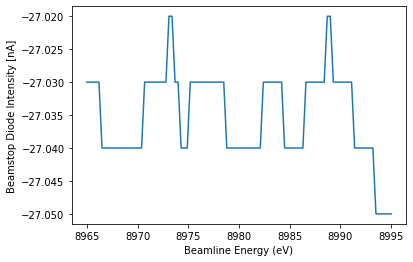

In [33]:
# make a quick plot of the photodiode signal

plt.plot(input_energies,pd_val_nA)
plt.xlabel('Beamline Energy (eV)')
plt.ylabel('Beamstop Diode Intensity [nA]')
plt.show()

# save data since photodiode signals are not archived (i think)!
file_name = 'scan01_nexafs_CopperFoil_photodiode'
#file_name = 'scan02_nexafs_CopperFoil_photodiode_dark'
#file_name = 'scan03_nexafs_CopperFoil_photodiode_dark2'

#np.savetxt(f'/home/bl531/bl531_commissioning/20240422ML_commissioning/{file_name}.txt', np.vstack((input_energies, mono_angles_deg, pd_val_nA)).T)

In [ ]:
# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# now i've pulled vacuum on a direct beam sample
# and i ran tulasis two PET-SeNP samples using these cells

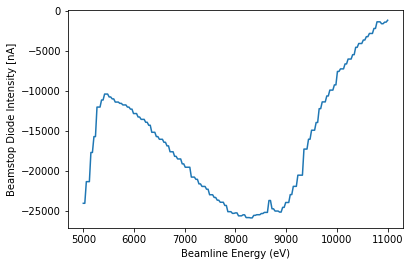

In [64]:
# lets do a wide energy scan on the photodiode to see what the bkg on is for a direct beam   

input_energies = np.linspace(5000, 11000, 201)
mono_angles_deg = mono_deg(input_energies)
pd_val_nA = mono_angles_deg*0

epics.caput('bl531_xps1:mono_angle_deg', mono_angles_deg[0])
time_sleep(5)
for i_a in np.arange(len(mono_angles_deg)):
    epics.caput('bl531_xps1:mono_angle_deg', mono_angles_deg[i_a])
    time_sleep(0.5)
    pd_val_nA[i_a] = epics.caget('bl201-beamstop:current')


# make a quick plot of the photodiode signal
plt.plot(input_energies,pd_val_nA)
plt.xlabel('Beamline Energy (eV)')
plt.ylabel('Beamstop Diode Intensity [nA]')
plt.show()

# save data since photodiode signals are not archived (i think)!
file_name = 'scan04_nexafs_directbeam_photodiode_dark'
file_name = 'scan05_nexafs_directbeam_photodiode'

#np.savetxt(f'/home/bl531/bl531_commissioning/20240422ML_commissioning/{file_name}.txt', np.vstack((input_energies, mono_angles_deg, pd_val_nA)).T)

In [25]:
# pilatus time :)  single image acquisition
aqtime_s = 1
epics.caput('13PIL1:cam1:AcquireTime', aqtime_s * 1.5)
epics.caput('13PIL1:cam1:AcquirePeriod', aqtime_s)
epics.caput('13PIL1:cam1:Acquire',1)
time_sleep(5)
last_filename_ascii = epics.caget('13PIL1:cam1:FullFileName_RBV')
last_filename = bytes(last_filename_ascii).decode()
print(last_filename)

/mnt/data531/scan08_saxs_tulasi-PET-SeNP2_4899.tif 


In [ ]:
# display 2d image 

#filepath = '/mnt/pilatus/' + 'BinaryNP_231222_WAXS_4802.tif'
#filepath = '/mnt/pilatus/' + 'FeNOM_20231221_3756.tif'
#filepath = 'afp://bl531user@bl531data.local/User_Data/' + last_filename[13:-1]
filepath = f'/home/bl531/bl531_commissioning/20240422ML_commissioning/{last_filename[13:-1]}'
#filepath = '/home/bl531/bl531_commissioning/20240422ML_commissioning/scan06_saxs_directbeam_5000-11000eV/scan06_saxs_directbeam_4882.tif'
filepath = '/home/bl531/bl531_commissioning/20240422ML_commissioning/scan07_saxs_tulasi-PET-ctrl_4894.tif'
filepath = '/home/bl531/bl531_commissioning/20240422ML_commissioning/scan08_saxs_tulasi-PET-SeNP2_4899.tif'


# read the image
im_tiff = Image.open(filepath)
# make the image a numpy array so that we can process it
im_np = np.squeeze(np.array(im_tiff.getdata()).reshape(im_tiff.size[1], im_tiff.size[0], 1))

# dealing with dyanmic range
#im_np[np.where(im_np>100000.0)] =0

dx_m = 172e-6
Nx_px = 981
Ny_px = 1043
Dx_m = Nx_px*dx_m
Dy_m = Ny_px*dx_m

fig=plt.figure(figsize=(5, 5), dpi= 120, facecolor='w', edgecolor='k')
extent = (-Dx_m/2 * 1e3, +Dx_m/2 * 1e3, -Dy_m/2 * 1e3, +Dy_m/2 * 1e3)

#mask = im_np > np.max(im_np)
#im_np[mask]=0

plt.imshow(im_np, extent=extent, cmap = 'inferno', norm=LogNorm())
plt.xlabel('horizontal Position [mm]')
plt.ylabel('vertical Positon [mm]')
plt.show()

In [ ]:
# check that you are not oversaturating detector... if so, adjust exposure time 

np.percentile(im_np,99.9)   # this value should be below 1 million

In [99]:
# pilatus energy scan

Es_eV = np.linspace(5000, 11000, 61)

epics.caput('bl531_xps1:mono_angle_deg',mono_deg(Es_eV[0]))
time_sleep(5)
filenames = ()
for i_e in range(len(Es_eV)):
    mono_angle_deg = mono_deg(Es_eV[i_e])
    
    epics.caput('bl531_xps1:mono_angle_deg',mono_angle_deg)
    time_sleep(2)

    aqtime_s = 1
    epics.caput('13PIL1:cam1:AcquireTime', aqtime_s * 1.5)
    epics.caput('13PIL1:cam1:AcquirePeriod', aqtime_s)
    epics.caput('13PIL1:cam1:Acquire',1)
    time_sleep(5)

    last_filename_ascii = epics.caget('13PIL1:cam1:FullFileName_RBV')
    last_filename = bytes(last_filename_ascii).decode()[13:-1]
    filenames += (last_filename,)


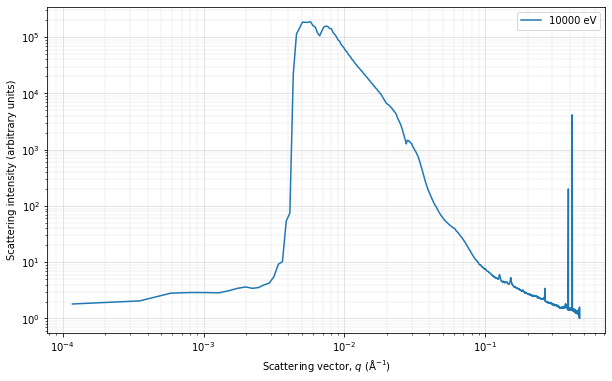

In [66]:
# radial integration of a single pilatus image

filepath = '/home/bl531/bl531_commissioning/20240422ML_commissioning/scan07_saxs_tulasi-PET-ctrl_10000eV/scan07_saxs_tulasi-PET-ctrl_4891.tif'
filepath = '/home/bl531/bl531_commissioning/20240422ML_commissioning/scan08_saxs_tulasi-PET-SeNP2_dark_4898.tif'
filepath = '/home/bl531/bl531_commissioning/20240422ML_commissioning/scan08_saxs_tulasi-PET-SeNP2_4899.tif'

az_range=[-180,180]
fig, ax = plt.subplots(figsize=(10,6))
#qvector_list = []
#radint_list = []
#energy_list = []
#for idx, image in tqdm(enumerate(images[:])):
mono_angle = 24.19
energy = 10000
#mono_angle = float(image[ image.find('deg') - 4: image.find('deg')])
#energy = calculate_output_energy(mono_angle)

# calibration performed in pyfai-calib2 by mrl on 4/22/24
dist = 1.47
poni1 = 0.10065476219862225
poni2 = 0.07695294434659085
rot1 = 0
rot2 = 0
rot3 = 0

wavelength = ( (4.1357 * (10**-15)) * (2.9979 * (10**8))) / energy
calibrant = pyFAI.calibrant.get_calibrant("AgBh")
calibrant.wavelength = wavelength
detector = pyFAI.detectors.Pilatus1M(pixel1=0.000172, pixel2=0.000172, max_shape=(1043, 981))
ai = AzimuthalIntegrator(dist=dist, detector=detector, wavelength=wavelength, poni1=poni1, poni2=poni2, rot1=rot1, rot2=rot2, rot3=rot3)
#ai.maskfile = os.path.join(master_path, 'waxs_mask_mrl_april2024.edf')

im_path = os.path.join(filepath)
im_data = fabio.open(im_path)
im_array = im_data.data
im_array[im_array < 1] = 1
im_reduced = ai.integrate1d(im_array, npt=2000, azimuth_range=az_range)
qvector = im_reduced[0] / 10
intensity = im_reduced[1] # / diode_value

#log_intensity = np.log10(intensity)
#log_intensity_offset = log_intensity - 1 * idx
#intensity_offset = 10**(log_intensity_offset)
#intensity = intensity_offset

#qvector_list.append(qvector)
#radint_list.append(intensity)
#energy_list.append(energy)
energy_rounded = round(energy, 0)
ax.plot(qvector, intensity, label=f'{energy_rounded} eV')
ax.set_xscale('log')
ax.set_yscale('log')    
#ax.set_title(f'Fe(OH)3 Sample\nRadially integrated WAXS profile\nEnergy={energy} eV')
ax.set_xlabel(r'Scattering vector, $q \ (\mathrm{\AA^{-1}})$')
ax.set_ylabel('Scattering intensity (arbitrary units)')
ax.grid(which='major', color='lightgrey', linewidth=0.6); ax.grid(which='minor', color='lightgrey', linewidth=0.3)
ax.legend()
plt.show()

#if flag_save:
#    path_saxs_plot = os.path.join(save_path, f'{sample_folder}_saxs_{energy}eV.tif')
#    path_saxs_txt = os.path.join(save_path, f'{sample_folder}_saxs_{energy}eV.txt')
#    fig.savefig(path_saxs_plot, bbox_inches='tight', dpi=300)
#    np.savetxt(path_saxs_txt, np.vstack((qvector, intensity)).T)



In [ ]:
# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# now i have the Copper Foil back in the chamber and i pulled vacuum
# want to try some spectroscopy (NEXAFS, EXAFS) at Cu K-edge

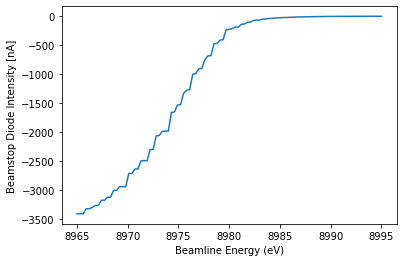

In [75]:
# lets look at the Cu K-edge

input_energies = np.linspace(8965, 8995, 101)
mono_angles_deg = mono_deg(input_energies)
pd_val_nA = mono_angles_deg*0

epics.caput('bl531_xps1:mono_angle_deg', mono_angles_deg[0])
time_sleep(5)
for i_a in np.arange(len(mono_angles_deg)):
    epics.caput('bl531_xps1:mono_angle_deg', mono_angles_deg[i_a])
    time_sleep(5)
    pd_val_nA[i_a] = epics.caget('bl201-beamstop:current')


# make a quick plot of the photodiode signal
plt.plot(input_energies,pd_val_nA)
plt.xlabel('Beamline Energy (eV)')
plt.ylabel('Beamstop Diode Intensity [nA]')
plt.show()

# save data since photodiode signals are not archived (i think)!
file_name = 'scan12_nexafs_CuFoil-vacuum_photodiode_5sec'



np.savetxt(f'/home/bl531/bl531_commissioning/20240422ML_commissioning/{file_name}.txt', np.vstack((input_energies, mono_angles_deg, pd_val_nA)).T)

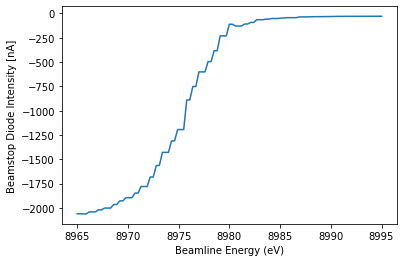

In [72]:
# 0.5 sec photodiode scan for reference (to compare to 5 sec scan above)

plt.plot(input_energies,pd_val_nA)
plt.xlabel('Beamline Energy (eV)')
plt.ylabel('Beamstop Diode Intensity [nA]')

plt.show()

In [ ]:
# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# antoines code from 20240422ML_calibration.ipynb

In [ ]:
# testing EPICS with the monochromator
epics.caget('bl531_xps1:mono_angle_deg')

CA.Client.Exception...............................................
    Context: "Channel: "bl531_xps1:mono_angle_deg", Connecting to: 131.243.80.239:5064, Ignored: 192.168.10.123:5064"
    Source File: ../cac.cpp line 1320
    Current Time: Mon Apr 22 2024 17:52:17.779838292
..................................................................


25.8

In [ ]:

epics.caget('bl201-beamstop:current')

CA.Client.Exception...............................................
    Context: "Channel: "bl201-beamstop:current", Connecting to: 131.243.80.239:39163, Ignored: 192.168.10.123:39163"
    Source File: ../cac.cpp line 1320
    Current Time: Mon Apr 22 2024 17:52:43.506558663
..................................................................


-122.83

In [ ]:
import matplotlib.pyplot as plt
from time import sleep as time_sleep

mono_angles_deg = np.linspace(25,26,101)
pd_val_nA = mono_angles_deg*0


epics.caput('bl531_xps1:mono_angle_deg', mono_angles_deg[0])
time_sleep(5)
for i_a in np.arange(len(mono_angles_deg)):
    epics.caput('bl531_xps1:mono_angle_deg', mono_angles_deg[i_a])
    time_sleep(0.5)
    pd_val_nA[i_a] = epics.caget('bl201-beamstop:current')




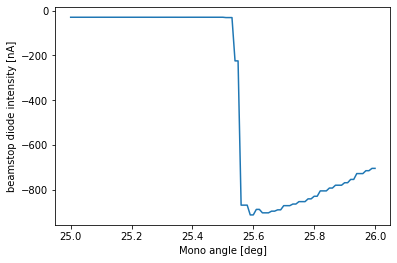

In [ ]:
plt.plot(mono_angles_deg,pd_val_nA)
plt.xlabel('Mono angle [deg]')
plt.ylabel('beamstop diode intensity [nA]')
plt.show()


In [ ]:
pd_val_nA

array([  -29.85,   -29.85,   -29.85,   -29.85,   -29.85,   -29.85,
         -29.85,   -29.85,   -29.85,   -29.85,   -29.85,   -29.85,
         -29.85,   -29.85,   -29.85,   -29.85,   -29.85,   -29.85,
         -29.85,   -29.85,   -29.85,   -29.85,   -29.81,   -29.81,
         -29.81,   -29.81,   -29.81,   -29.81,   -29.81,   -29.81,
         -29.81,   -29.81,   -29.81,   -29.81,   -29.8 ,   -29.8 ,
         -29.8 ,   -29.8 ,   -29.8 ,   -29.8 ,   -29.8 ,   -29.8 ,
         -29.8 ,   -29.8 ,   -29.8 ,   -29.8 ,   -29.78,   -29.78,
         -29.78,   -29.78,   -29.78,   -29.78,   -29.78,   -29.78,
         -29.78,   -29.78,   -29.78,   -29.78,   -29.81,   -29.81,
         -29.81,   -29.81,   -29.81,   -29.81,   -29.81,   -29.81,
         -29.81,   -29.81,   -29.81,   -29.81, -1204.  , -1204.  ,
       -1204.  , -1204.  , -1204.  , -1204.  , -1204.  , -1204.  ,
       -1204.  , -1204.  , -1204.  ,  -835.7 ,  -835.7 ,  -835.7 ,
        -835.7 ,  -835.7 ,  -835.7 ,  -835.7 ,  -835.7 ,  -835